In [50]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq

In [51]:
# Observed data
x = [  1.4557,  3.1200,  2.2762,  1.7253,  1.6040,    1.4986,  1.5503,  1.5412,1.5871,  1.5805,    1.4554,    1.4667,    1.4259,    1.4568,    1.4722,    1.4985,    1.5788,    1.5901,    1.5372,    1.5805,    1.5054,    1.5012,    1.4464,    1.5790,    1.6125,    1.5469]
y = [ 0.2383,    1.9637,    2.0233,    1.5525,    0.8493,    0.4720,    0.3195,    0.2758,    0.2557,    0.2447,    0.2605,    0.2719,    0.2513,    0.3371,    0.2646,    0.2475,    0.2593,    0.2556,    0.2450,    0.2256,    0.2489,    0.2612, 0.2591,    0.2959,    0.3152,    0.2526]
ode_data = transpose(hcat(x,y))
u0 = [x[1],y[1]]
tspan = (0.0f0, 1.5f0)
t = range(tspan[1], tspan[2], length = 26)
species1 = "EGF50_ppMEK"
species2 = "EGF50_ppERK";

In [52]:
# Structure to observe training
mutable struct saver
    losses::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,times,count_epochs)
end
function update_saver(saver, loss_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

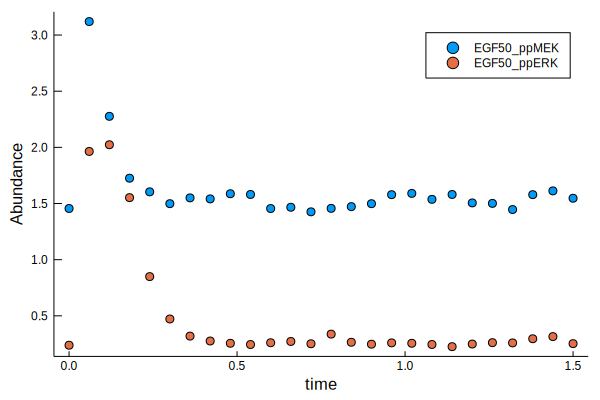

In [53]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1 )
scatter!(t, ode_data[2,:], label = species2 )

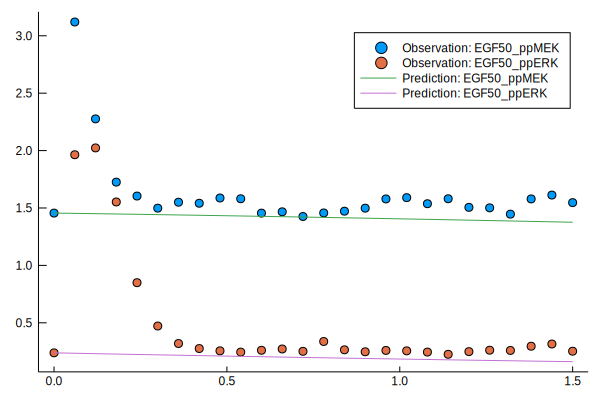

In [58]:
# Building a neural ODE and see starting point
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(2,100, tanh),
       Dense(100,100, tanh),
       Dense(100,100, tanh),
       Dense(100,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat = t, reltol = 1e-7, abstol = 1e-9)
n_epochs = 200
sa_l2 = saver(n_epochs)
# L2 loss
L2_loss_fct() = sum(abs2, ode_data .- n_ode(u0))
# Callback function to observe L2 training.
cb = function ()
    sa_l2.count_epochs = sa_l2.count_epochs +  1
    update_saver(sa_l2, Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
    #println("\"", Tracker.data(L2_loss_fct()), "\" \"", Dates.Time(Dates.now()), "\";")
end

pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [ ]:
# train n_ode with L2 norm
opt = ADAM(0.1)
data = Iterators.repeated((), n_epochs)
@time Flux.train!(L2_loss_fct, ps, data, opt, cb = cb)

In [ ]:
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [ ]:
header = string("l2 losses:",sa_l2.times[end]-sa_l2.times[1])
plot(range(1, stop = length(sa_l2.losses)), log.(sa_l2.losses), width = 2, label = header, grid = "off")